Cuaderno de prueba para testear la capacidad de entrenamiento

In [1]:
# Importar librerías
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np

import requests
import copy

from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os

In [2]:
# Importar el manejador de modelo: ModelHandler
from pv_vision.nn import ModelHandler

In [4]:
# Se definió una clase para el conjunto de datos solar, que hereda de la clase VisionDataset de PyTorch.
class SolarDataset(VisionDataset):
    """Un conjunto de datos que lee directamente las imágenes y las máscaras desde una carpeta."""
    
    # Se definió el método de inicialización para la clase.
    def __init__(self, 
                 root, 
                 image_folder, 
                 mask_folder,
                 transforms,
                 mode = "train",
                 random_seed=42):
        # Se llamó al método de inicialización de la clase padre.
        super().__init__(root, transforms)
        # Se establecieron las rutas a las carpetas de imágenes y máscaras.
        self.image_path = Path(self.root) / image_folder
        self.mask_path = Path(self.root) / mask_folder

        # Se verificó que las carpetas de imágenes y máscaras existan.
        if not os.path.exists(self.image_path):
            raise OSError(f"{self.image_path} no encontrado.")

        if not os.path.exists(self.mask_path):
            raise OSError(f"{self.mask_path} no encontrado.")

        # Se obtuvieron las listas de imágenes y máscaras y se ordenaron.
        self.image_list = sorted(list(list_images(self.image_path)))
        self.mask_list = sorted(list(list_images(self.mask_path)))

        # Se convirtieron las listas de imágenes y máscaras a arrays de numpy.
        self.image_list = np.array(self.image_list)
        self.mask_list = np.array(self.mask_list)

        # Se estableció la semilla para la generación de números aleatorios y se mezclaron las imágenes y las máscaras.
        np.random.seed(random_seed)
        index = np.arange(len(self.image_list))
        np.random.shuffle(index)
        self.image_list = self.image_list[index]
        self.mask_list = self.mask_list[index]

    # Se definió el método para obtener la longitud del conjunto de datos.
    def __len__(self):
        return len(self.image_list)

    # Se definió un método para obtener el nombre de una imagen o máscara.
    def __getname__(self, index):
        image_name = os.path.splitext(os.path.split(self.image_list[index])[-1])[0]
        mask_name = os.path.splitext(os.path.split(self.mask_list[index])[-1])[0]

        if image_name == mask_name:
            return image_name
        else:
            return False
    
    # Se definió un método para obtener una imagen y su máscara correspondiente.
    def __getraw__(self, index):
        if not self.__getname__(index):
            raise ValueError("{}: La imagen no coincide con la máscara".format(os.path.split(self.image_list[index])[-1]))
        image = Image.open(self.image_list[index])
        mask = Image.open(self.mask_list[index]).convert('L')
        mask = np.array(mask)
        mask = Image.fromarray(mask)

        return image, mask

    # Se definió el método para obtener un elemento del conjunto de datos.
    def __getitem__(self, index):
        image, mask = self.__getraw__(index)
        image, mask = self.transforms(image, mask)

        return image, mask


El código anterior define una clase para un conjunto de datos de imágenes solares. La clase tiene métodos para obtener la longitud del conjunto de datos, obtener el nombre de una imagen o máscara, obtener una imagen y su máscara correspondiente, y obtener un elemento del conjunto de datos.

In [5]:
# Se definió una clase para componer varias transformaciones.
class Compose:
    def __init__(self, transforms):
        """
        transforms: una lista de transformaciones
        """
        self.transforms = transforms
    
    # Se definió el método para aplicar las transformaciones a la imagen y la máscara.
    def __call__(self, image, target):
        """
        image: imagen de entrada
        target: máscara de entrada
        """
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# Se definió una clase para redimensionar la imagen y la máscara a un tamaño fijo.
class FixResize:
    # UNet requiere que el tamaño de entrada sea múltiplo de 16
    def __init__(self, size):
        self.size = size

    # Se definió el método para redimensionar la imagen y la máscara.
    def __call__(self, image, target):
        image = F.resize(image, (self.size, self.size), interpolation=transforms.InterpolationMode.BILINEAR)
        target = F.resize(target, (self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST)
        return image, target

# Se definió una clase para transformar la imagen y la máscara a tensores.
class ToTensor:
    """Transforma la imagen a tensor. Escala la imagen a [0,1] float32.
    Transforma la máscara a tensor.
    """
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

# Se definió una clase para transformar la imagen a tensor manteniendo el tipo original.
class PILToTensor:
    """Transforma la imagen a tensor. Mantiene el tipo original."""
    def __call__(self, image, target):
        image = F.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

# Se definió una clase para normalizar la imagen.
class Normalize:
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std
    
    # Se definió el método para normalizar la imagen.
    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target


El código anterior define varias clases para transformaciones de imágenes y máscaras, incluyendo la composición de varias transformaciones, el redimensionamiento a un tamaño fijo, la transformación a tensores y la normalización.

In [6]:
# Las imágenes y etiquetas son solo para demostración tutorial.
# El conjunto de datos completo que usamos para el desarrollo del modelo se puede encontrar aquí:
# https://datahub.duramat.org/dataset/00b29daf-239c-47b6-bd96-bfb0875179a8/resource/c6626a05-e82f-4732-ade9-ec5441b83e46/download/crack_segmentation.zip

# Se establece la ruta al directorio raíz que contiene las imágenes y las etiquetas.
root = Path('/home/franklin/PV_vision/pv-vision/examples/crack_segmentation/img_label_for_training')


# Se definen las transformaciones a aplicar a las imágenes y las etiquetas.
transformers = Compose([FixResize(256), ToTensor(), Normalize()])

# Se crean los conjuntos de datos de entrenamiento, validación y prueba.
trainset = SolarDataset(root, image_folder="train/img", 
        mask_folder="train/ann", transforms=transformers)

valset = SolarDataset(root, image_folder="val/img", 
        mask_folder="val/ann", transforms=transformers)

testset = SolarDataset(root, image_folder="testset/img", 
        mask_folder="testset/ann", transforms=transformers)



Este código define la ruta al directorio raíz que contiene las imágenes y las etiquetas, las transformaciones a aplicar a las imágenes y las etiquetas, y crea los conjuntos de datos de entrenamiento, validación y prueba.

In [7]:
# Verificación de que la carpeta haya sido establecida correctamente
print(f"El conjunto de datos de entrenamiento contiene {len(trainset)} elementos.")

El conjunto de datos de entrenamiento contiene 972 elementos.


In [8]:
# Se define una función para crear un modelo DeepLab preentrenado.
def DeepLab_pretrained(num_classes):
    # Se carga el modelo DeepLab con una arquitectura ResNet50 preentrenada.
    deeplab = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
    
    # Se reemplaza el clasificador del modelo con un nuevo clasificador DeepLabHead.
    # El nuevo clasificador tiene 2048 características de entrada y 'num_classes' características de salida.
    deeplab.classifier = DeepLabHead(2048, num_classes)
    
    # Se devuelve el modelo modificado.
    return deeplab



Este código define una función para crear un modelo DeepLab preentrenado con una arquitectura ResNet50 y reemplazar su clasificador con un nuevo clasificador que tiene un número específico de características de salida.

In [9]:
# Se define el dispositivo en el que se ejecutará el modelo. Si hay una GPU disponible, se usará. De lo contrario, se usará la CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Se imprime el dispositivo utilizado.
print(f"Dispositivo utilizado: {device}")

# Se crea el modelo utilizando la función DeepLab_pretrained definida anteriormente. 
# El modelo se envuelve en un objeto DataParallel para permitir el entrenamiento en múltiples GPUs si están disponibles.
model = DataParallel(DeepLab_pretrained(5))

# Se define la función de pérdida a utilizar durante el entrenamiento. En este caso, se utiliza la pérdida de entropía cruzada.
criterion = CrossEntropyLoss()

# Se define el optimizador a utilizar durante el entrenamiento. En este caso, se utiliza Adam con una tasa de aprendizaje de 0.01.
optimizer = Adam(model.parameters(), lr=0.01)

# Se define el programador de la tasa de aprendizaje a utilizar durante el entrenamiento. 
# En este caso, se utiliza un programador de paso que disminuye la tasa de aprendizaje en un factor de 0.2 cada 5 épocas.
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

/home/franklin/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Dispositivo utilizado: cpu



El código anterior define el dispositivo en el que se ejecutará el modelo, crea el modelo, define la función de pérdida, el optimizador y el programador de la tasa de aprendizaje a utilizar durante el entrenamiento.

In [9]:
# Se inicializa el manejador del modelo.
# La salida se almacena en la carpeta de salida.
modelhandler = ModelHandler(
    # Se pasa el modelo que se va a entrenar.
    model=model,
    
    # Se especifica el nombre de la carpeta de salida.
    model_output='out',
    
    # Se pasan los conjuntos de datos de entrenamiento, validación y prueba.
    train_dataset=trainset,
    val_dataset=valset,
    test_dataset=testset,
    
    # Se especifica el tamaño del lote para el entrenamiento y la validación.
    batch_size_train=32,
    batch_size_val=32,
    
    # Se pasa el programador de la tasa de aprendizaje.
    lr_scheduler=lr_scheduler,
    
    # Se especifica el número de épocas para el entrenamiento.
    num_epochs=10,
    
    # Se pasa la función de pérdida y el optimizador.
    criterion=criterion,
    optimizer=optimizer,
    
    # Se pasa el dispositivo en el que se ejecutará el entrenamiento.
    device=device,
    
    # Se especifica el directorio donde se guardarán los puntos de control del modelo.
    save_dir='checkpoints',
    
    # Se especifica el nombre del archivo de punto de control.
    save_name='deeplab.pt'
)



Este código inicializa un manejador de modelo con varios parámetros, incluyendo el modelo a entrenar, los conjuntos de datos de entrenamiento, validación y prueba, el tamaño del lote, el programador de la tasa de aprendizaje, el número de épocas, la función de pérdida, el optimizador, el dispositivo, el directorio de guardado y el nombre del archivo de punto de control.

In [10]:
modelhandler.batch_size_train = 8  # Reduce the batch size to 16
modelhandler.train_model()

Epoch 1 / 10
----------


  0%|          | 0/31 [00:00<?, ?it/s]


Este código entrena el modelo utilizando el manejador de modelo. El número de épocas se especificó al inicializar el manejador de modelo.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


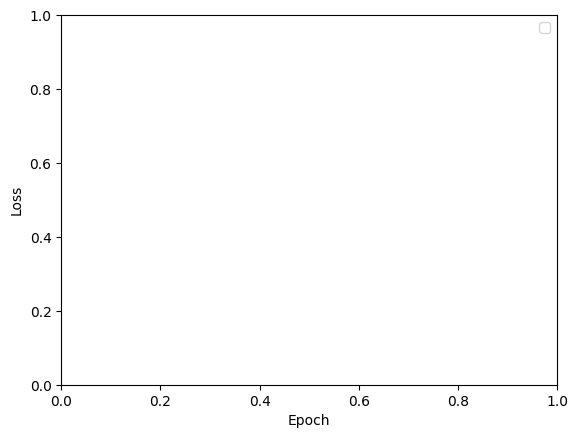

In [ ]:
# Se visualiza el proceso de entrenamiento.
# Esta función traza la pérdida del modelo durante el entrenamiento.
modelhandler.plot_loss()



Este código traza la pérdida del modelo durante el entrenamiento utilizando el manejador de modelo.

In [ ]:
# Se busca la pérdida mínima en la validación, que corresponde al mejor modelo.
# 'np.argmin' devuelve el índice de la pérdida mínima en el conjunto de validación.
# Se suma 1 porque los índices en Python comienzan en 0, pero las épocas comienzan en 1.
np.argmin(modelhandler.running_record['val']['loss'])+1

ValueError: attempt to get argmin of an empty sequence



Este código busca la pérdida mínima en el conjunto de validación, que corresponde al mejor modelo. Se suma 1 al índice devuelto por 'np.argmin' porque los índices en Python comienzan en 0, pero las épocas comienzan en 1.

In [ ]:
# Podemos cargar el mejor modelo y verificar su rendimiento en el conjunto de prueba.
# 'load_model' es una función del manejador de modelo que carga un modelo desde un archivo de punto de control.
modelhandler.load_model('checkpoints/epoch_10/deeplab.pt')

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.




Este código carga el mejor modelo desde un archivo de punto de control y lo prepara para verificar su rendimiento en el conjunto de prueba.

In [ ]:
# Se prueba el modelo en el conjunto de prueba y se almacena la salida en 'testset_output'.
# 'test_model' es una función del manejador de modelo que prueba el modelo en el conjunto de prueba.
_ = modelhandler.test_model(cache_output='testset_output')

# La salida del modelo se almacena en self.cache['testset_output']


Este código prueba el modelo en el conjunto de prueba y almacena la salida en 'testset_output'. También se hace un comentario sobre la puntuación de la prueba y la puntuación de la validación.